In [1]:
!pip install tensorflow-probability==0.19.0 tqdm==4.64.1

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from math import ceil
from dataclasses import dataclass
from typing import List

import gym
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from keras import Model
from keras.layers import \
    Input, Dense, Reshape, Lambda, Flatten, \
    Conv2D, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from keras.metrics import Mean

tfpl = tfp.layers
tfd = tfp.distributions
IndependentNormal = tfp.layers.IndependentNormal
Independent = tfp.distributions.Independent
Normal = tfp.distributions.Normal

In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.11.0
/device:GPU:0


In [4]:
@dataclass
class DreamerSettings:
    action_dims: List[int]
    obs_dims: List[int]
    repr_dims: List[int]
    hidden_dims: List[int]
    enc_dims: List[int]
    dropout_rate: float = 0.2

    @property
    def repr_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1]

    @property
    def repr_out_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1] + self.hidden_dims[0]

In [5]:
settings = DreamerSettings([1], [28, 28, 1], [32, 32], [512], [128])

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
train_imgs = tf.data.Dataset.from_tensor_slices(tensors=(x_train))
test_imgs = tf.data.Dataset.from_tensor_slices(tensors=(x_test))
train_dataset = train_imgs.map(lambda obs: tf.reshape(obs, (28, 28, 1)) / 255.0)
eval_dataset = test_imgs.map(lambda obs: tf.reshape(obs, (28, 28, 1)) / 255.0)

train_dataset = train_dataset.map(lambda obs: (obs, obs))
eval_dataset = eval_dataset.map(lambda obs: (obs, obs))

batch_size = 64
train_dataset = train_dataset.batch(batch_size)
eval_dataset = eval_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(100)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
def create_state_encoder_model(settings: DreamerSettings) -> Model:
    enc_units = settings.enc_dims[0] * 2
    model_in = Input(settings.obs_dims, name="obs")
    norm_img = Lambda(lambda x: x * 2.0 - 1.0)
    cnn_1 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2D(64, (3, 3), padding="same", activation="elu")
    cnn_4 = Conv2D(8, (3, 3), padding="same", activation="elu")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    drop_4 = Dropout(rate=settings.dropout_rate)
    flatten = Flatten()
    dense_out = Dense(enc_units, activation="linear", name="enc_dense")

    img_in = norm_img(model_in)
    prep_model_convs = drop_4(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(img_in))))))))
    model_out = dense_out(flatten(prep_model_convs))
    return Model(inputs=model_in, outputs=model_out, name="encoder_model")


def create_representation_model(settings: DreamerSettings) -> Model:
    enc_dims = settings.enc_dims[0]
    model_in = Input((enc_dims * 2))

    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dims), scale=1))
    split = Lambda(lambda x: (x[:, :enc_dims], x[:, enc_dims:]))
    posterior = Lambda(lambda x: x[0] + x[2].sample() * tf.math.exp(x[1] / 2.0))

    mu, sigma = split(model_in)
    model_out = posterior((mu, sigma, prior))
    return Model(inputs=[model_in], outputs=[model_out, (mu, sigma)])


def create_state_decoder_model(settings: DreamerSettings) -> Model:
    image_channels = settings.obs_dims[-1]
    in_height, in_width = settings.obs_dims[0] // 4, settings.obs_dims[1] // 4
    upscale_source_dims = in_height * in_width * 8

    model_in = Input(settings.enc_dims[0], name="repr_out")
    dense_in = Dense(upscale_source_dims, activation="linear", name="dec_in")
    reshape_in = Reshape((in_height, in_width, -1))
    cnn_1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2DTranspose(64, (3, 3), padding="same", activation="elu")
    cnn_4 = Conv2D(64, (3, 3), padding="same", activation="elu")
    cnn_5 = Conv2D(image_channels, (1, 1), padding="same", activation="linear")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)

    prep_in = reshape_in(dense_in(model_in))
    model_out = cnn_5(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(prep_in))))))))
    return Model(inputs=model_in, outputs=model_out, name="decoder_model")


def compose_model(settings: DreamerSettings) -> Model:
    encoder = create_state_encoder_model(settings)
    latent_model = create_representation_model(settings)
    decoder = create_state_decoder_model(settings)

    model_in = Input(settings.obs_dims)
    enc_out = encoder(model_in)
    z, (mu, log_sigma) = latent_model(enc_out)
    reconst_img = decoder(z)

    return Model(inputs=[model_in], outputs=[reconst_img, mu, log_sigma])

In [12]:
@tf.function
def train_step(model, optimizer, batch):
    x, y_true = batch

    with tf.GradientTape() as tape:
        reconst_image, mu, logsigma = model(x)
        reconst_loss = tf.reduce_mean((reconst_image - y_true)**2)
        elbo_loss = -tf.reduce_mean(1.0 + logsigma - mu**2 - tf.math.exp(logsigma))
        loss = reconst_loss + 0.01 * elbo_loss

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return reconst_loss, elbo_loss


@tf.function
def eval_step(model, batch):
    x, y_true = batch

    reconst_image, mu, logsigma = model(x)
    reconst_loss = tf.reduce_mean((reconst_image - y_true)**2)
    elbo_loss = -tf.reduce_mean(1.0 + logsigma - mu**2 - tf.math.exp(logsigma))

    return reconst_loss, elbo_loss


def log_losses(writer, step, reconst_loss, elbo_loss, mode: str):
    with writer.as_default():
        tf.summary.scalar(f"{mode}/reconst_loss", reconst_loss, step=step)
        tf.summary.scalar(f"{mode}/elbo_loss", elbo_loss, step=step)
        tf.summary.scalar(f"{mode}/total_loss", reconst_loss + elbo_loss, step=step)


def create_model():
    model = compose_model(settings)
    model.build([None] + settings.obs_dims)
    model.summary()
    return model


def train(model, epochs: int):
    optimizer = Adam()
    train_ds_iter = iter(train_dataset)
    eval_ds_iter = iter(eval_dataset)

    writer = tf.summary.create_file_writer("logs/vae")
    mean_reconst_loss = Mean()
    mean_elbo_loss = Mean()

    for ep in tqdm(range(epochs)):
        for batch in train_ds_iter:
            reconst_loss, elbo_loss = train_step(model, optimizer, batch)
            mean_reconst_loss(reconst_loss)
            mean_elbo_loss(elbo_loss)

        reconst_loss = mean_reconst_loss.result()
        elbo_loss = mean_elbo_loss.result()
        log_losses(writer, ep, reconst_loss, elbo_loss, "train")
        mean_reconst_loss.reset_states()
        mean_elbo_loss.reset_states()

        for batch in eval_ds_iter:
            reconst_loss, elbo_loss = eval_step(model, batch)
            mean_reconst_loss(reconst_loss)
            mean_elbo_loss(elbo_loss)

        reconst_loss = mean_reconst_loss.result()
        elbo_loss = mean_elbo_loss.result()
        log_losses(writer, ep, reconst_loss, elbo_loss, "eval")
        mean_reconst_loss.reset_states()
        mean_elbo_loss.reset_states()

In [13]:
model = create_model()
train(model, epochs=20)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 256)               179720    
                                                                 
 model_4 (Functional)        [(None, 128),             0         
                              ((None, 128),                      
                              (None, 128))]                      
                                                                 
 decoder_model (Functional)  (None, 28, 28, 1)         166089    
                                                                 
Total params: 345,809
Trainable params: 345,809
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


In [14]:
import matplotlib.pyplot as plt

def display_imgs(labels, preds):
    plt.ioff()
    n = labels.shape[0]
    fig, axs = plt.subplots(n, 3, figsize=(128, 128))
    for i in range(n):
        diff = preds[i] - labels[i]
        min_val, max_val = np.min(diff), np.max(diff)
        diff = (diff - min_val) / (max_val - min_val) if max_val - min_val != 0 else diff

        axs[i, 0].imshow(labels[i], interpolation='nearest', cmap='gray')
        axs[i, 1].imshow(preds[i], interpolation='nearest', cmap='gray')
        axs[i, 2].imshow(diff, interpolation='nearest', cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])
        axs[i, 2].set_xticks([])
        axs[i, 2].set_yticks([])

    fig.set_size_inches(10, n*5)
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()
    plt.close()

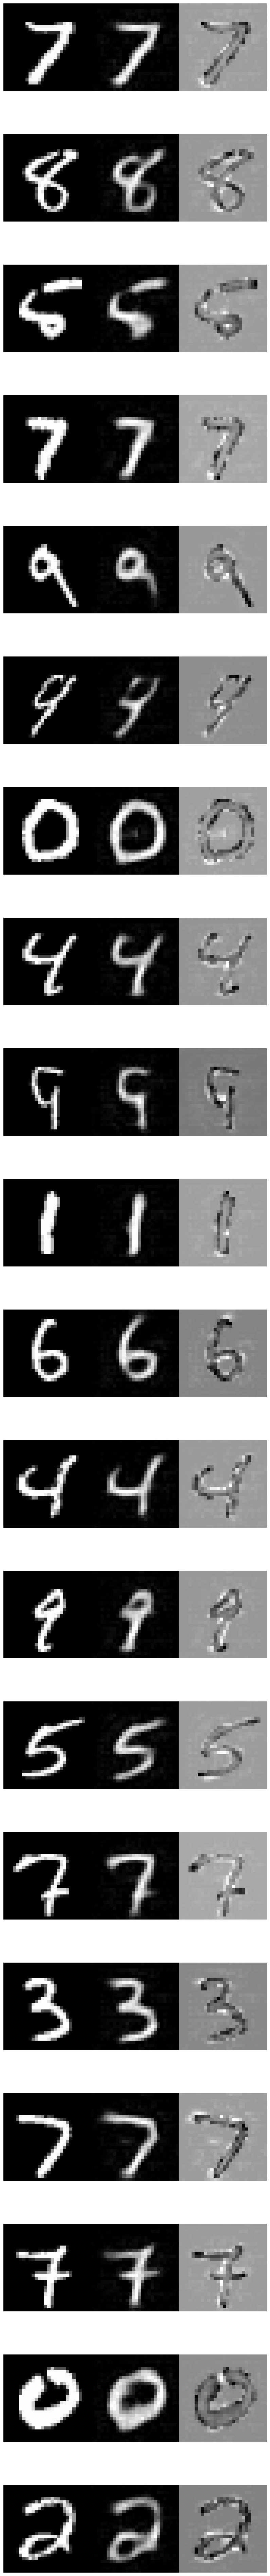

In [15]:
num_rows = 20
img_dataset = eval_dataset.unbatch().shuffle(100).batch(num_rows)
img_in, _ = iter(img_dataset).next()
img_out, _, __ = model(img_in)
img_in = img_in.numpy()[:num_rows]
img_out = np.clip(img_out.numpy()[:num_rows], 0, 1)

display_imgs(img_in, img_out)